In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T100019Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D522abf1eed9f1e0d7c610d55f03c0d9f0f488e5d37000362def3cef3e47f8f9df2677af4f6becb54fdd3463d344f19dd8488758b3c486c4d565fda0791048088a8b9767d60a91a3acc490b95ae1628d6ee6be28e8d6a6efa7c657c32a42f55022ca2b65685261dee177656d2896972c76228bea1de2cce1083e7fb8f7b62d222eaeacfb51dc1e592faf04534678ec4622dec53e890b4b5f0a77d580e73ebe3124dd14b434ea997be81f697c8245de098903e6d7694f753679f444fd2ee53c95c387cba3c860cfbc8eb22b59ca9d34c9a1d984c5996a329499d0cb364c0c59ed404a3e45925ed3327436130ab8ee7387a197f96ed36f21342e61bfe70bfc4850c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


In [ ]:
import os
import numpy as np
import pandas as pd
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
base_dir = '../input/chest-xray-pneumonia/chest_xray/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))


Total images: 5856
Total pneumonia images: 4273
Total Nomral images: 1583


In [ ]:
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

# We need to undersapmle the model so we take less number of pnuemonia chest images

train_imgs = pn[:1224]+ normal[:1224]  # 80% of 4273 Pneumonia and normal chest X-ray are 3418 and 1224 respectively.
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[1502:len(normal)] + normal[1502:len(normal)]

print(f"Total Train Images {len(train_imgs)} containing {len(pn[:1224])} pneumonia and {len(normal[:1224])} normal images")
print(f"Total Test Images {len(test_imgs)} containing {len(pn[1224:1502])} pneumonia and {len(normal[1224:1502])} normal images")
print(f"Total validation Images {len(val_imgs)} containing {len(pn[1502:len(normal)])} pneumonia and {len(normal[1502:len(normal)])} normal images" )

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)


Total Train Images 2448 containing 1224 pneumonia and 1224 normal images
Total Test Images 919 containing 278 pneumonia and 278 normal images
Total validation Images 162 containing 81 pneumonia and 81 normal images


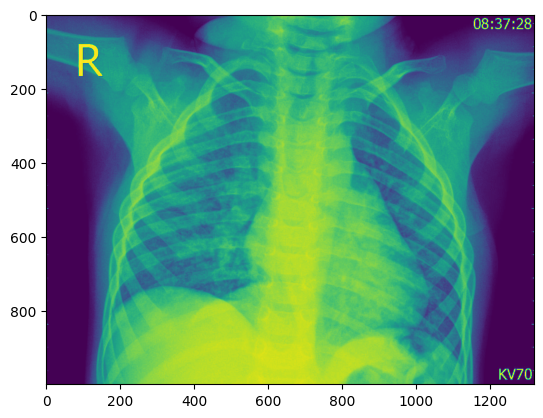

In [ ]:
# showing a random image

idx = random.randint(0, len(train_imgs))
img_path = train_imgs[idx]
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()


In [ ]:
img_size = 224

def preprocess_image(image_list):

    X = []  # Images
    y = []  # Labels (0 for Normal or 1 for Pneumonia)
    count = 0

    for image in image_list:

        try:
            # Load the image
            img = cv2.imread(image)

            # Resize the image
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)

            # Normalize image
            img = img.astype(np.float32) / 255.0

            count += 1

            X.append(img)

        except Exception as e:
            print(f"Error processing image {image}: {e}")
            continue

        # Get the labels
        if 'NORMAL' in image or 'IM' in image:
            y.append(0)
        elif 'virus' in image or 'bacteria' in image:
            y.append(1)

    return X, y

In [ ]:
X_learn, y_learn = preprocess_image(train_imgs)

In [ ]:
# Check all the images getting labels or not
arr=y_learn
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [1224 1224]


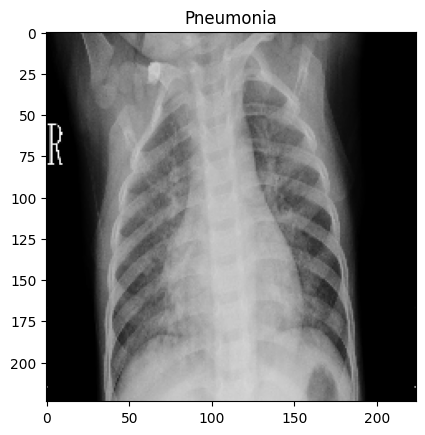

In [ ]:
# Display an image from train set

idx2 = random.randint(0, len(X))

plt.imshow(X_learn[idx2])

if (y[idx2]==0):
    plt.title('Normal')
else:
    plt.title('Pneumonia')

plt.imshow(X_learn[idx2])

plt.show()


In [ ]:
# labels for testing
X_test, y_test = preprocess_image(test_imgs)

In [ ]:
X_validation, y_validation = preprocess_image(val_imgs)

#Training

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Making data suitable for training

In [ ]:
X_learn = np.array(X_learn)
y_learn = np.array(y_learn)
y_learn = y_learn.reshape(len(y_learn), 1)

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = y_test.reshape(len(y_test), 1)

X_validation = np.array(X_validation)
y_validation = np.array(y_validation)
y_validation = y_validation.reshape(len(y_validation), 1)

In [ ]:
# Confirming the shape of arrays
print(f"Shape of X_learn is {X_learn.shape}")
print(f"Shape of y_learn is {y_learn.shape}")
print(f"Shape of X_test is {X_test.shape}")
print(f"Shape of y_test is {y_test.shape}")
print(f"Shape of X_validation is {X_validation.shape}")
print(f"Shape of y_validation is {y_validation.shape}")

Shape of X_learn is (2448, 224, 224, 3)
Shape of y_learn is (2448, 1)
Shape of X_test is (919, 224, 224, 3)
Shape of y_test is (919, 1)
Shape of X_validation is (162, 224, 224, 3)
Shape of y_validation is (162, 1)


In [ ]:
model.fit(X_learn, y_learn, epochs=5, batch_size=128, validation_data=(X_validation, y_validation))

Epoch 1/5
20/20 [==============================] - 47s 1s/step - loss: 0.5562 - accuracy: 0.8538 - val_loss: 0.4415 - val_accuracy: 0.8395
Epoch 2/5
20/20 [==============================] - 11s 535ms/step - loss: 0.0936 - accuracy: 0.9653 - val_loss: 0.5958 - val_accuracy: 0.7901
Epoch 3/5
20/20 [==============================] - 11s 537ms/step - loss: 0.0608 - accuracy: 0.9783 - val_loss: 0.4185 - val_accuracy: 0.8210
Epoch 4/5
20/20 [==============================] - 10s 515ms/step - loss: 0.0406 - accuracy: 0.9882 - val_loss: 0.6215 - val_accuracy: 0.7901
Epoch 5/5
20/20 [==============================] - 10s 517ms/step - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.7940 - val_accuracy: 0.7593


In [ ]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 14s 290ms/step - loss: 0.3755 - accuracy: 0.8912


[0.37549176812171936, 0.8911860585212708]

In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(loss= 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.fit(X_learn, y_learn, epochs=5, batch_size=128, validation_data=(X_validation, y_validation))

Epoch 1/5
20/20 [==============================] - 9s 190ms/step - loss: 0.8957 - accuracy: 0.6234 - val_loss: 0.5487 - val_accuracy: 0.7469
Epoch 2/5
20/20 [==============================] - 2s 123ms/step - loss: 0.3308 - accuracy: 0.8717 - val_loss: 0.3283 - val_accuracy: 0.8889
Epoch 3/5
20/20 [==============================] - 3s 139ms/step - loss: 0.1882 - accuracy: 0.9265 - val_loss: 0.3493 - val_accuracy: 0.8519
Epoch 4/5
20/20 [==============================] - 3s 139ms/step - loss: 0.1171 - accuracy: 0.9583 - val_loss: 0.4089 - val_accuracy: 0.8272
Epoch 5/5
20/20 [==============================] - 2s 121ms/step - loss: 0.0947 - accuracy: 0.9636 - val_loss: 1.1036 - val_accuracy: 0.6173


In [ ]:
model2.evaluate(X_test, y_test)

29/29 [==============================] - 1s 26ms/step - loss: 0.3019 - accuracy: 0.8825


[0.3018861711025238, 0.8824809789657593]

# Model Evaluation

In [ ]:
pred = model.predict(X_test)
predictions = (pred > 0.5).astype(int).flatten()
predicted_labels = np.argmax(predictions)
true_labels = np.argmax(y_test, axis=1)

29/29 [==============================] - 3s 118ms/step


In [ ]:
pred2 = model2.predict(X_test)
predictions2 = (pred2 > 0.5).astype(int).flatten()
predicted2_labels = np.argmax(predictions2)
true_labels2 = np.argmax(y_test, axis=1)

29/29 [==============================] - 1s 31ms/step


In [ ]:
# Evaluation for pretrained model
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79       278
           1       0.87      0.99      0.93       641

    accuracy                           0.89       919
   macro avg       0.92      0.83      0.86       919
weighted avg       0.90      0.89      0.88       919



In [ ]:
# Evaluation for CNN model
print(classification_report(y_test, predictions2))

              precision    recall  f1-score   support

           0       0.97      0.46      0.62       278
           1       0.81      0.99      0.89       641

    accuracy                           0.83       919
   macro avg       0.89      0.73      0.76       919
weighted avg       0.86      0.83      0.81       919



#Model Comparison
##Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, predictions)

In [ ]:
cm2 = confusion_matrix(y_test, predictions2)

[[<matplotlib.axis.XTick at 0x7f5da05fb640>,
 Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0, 0.5, 'True label'),
 Text(0.5, 0, 'Predictions')]

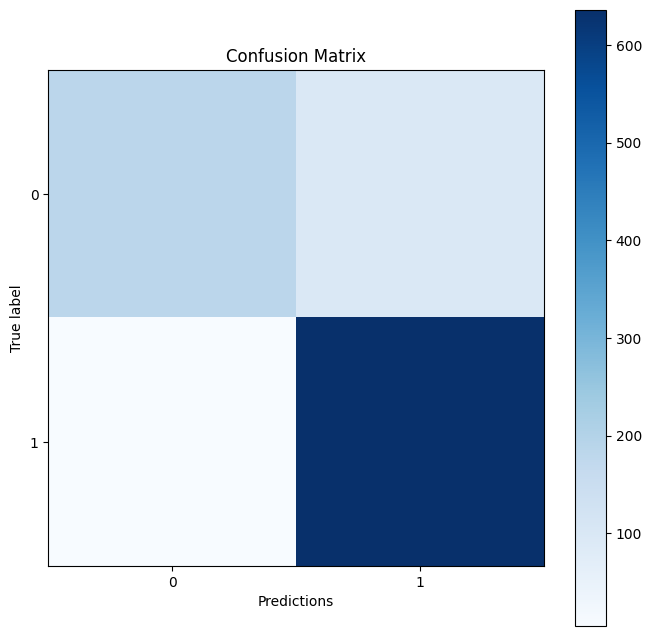

In [ ]:
# Plot the confusion matrix for pretrained model
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      title='Confusion Matrix',
      ylabel='True label',
      xlabel='Predictions')

[[<matplotlib.axis.XTick at 0x7f5da01912d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')],
 [Text(0, 0, '0'), Text(0, 1, '1')],
 Text(0.5, 1.0, 'Confusion Matrix'),
 Text(0, 0.5, 'True label'),
 Text(0.5, 0, 'Predictions')]

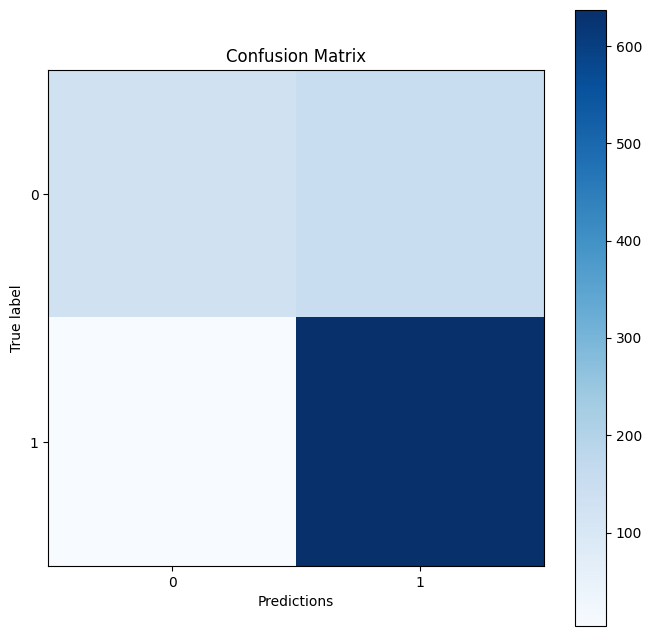

In [ ]:
# Plot the confusion matrix for CNN model
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm2, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm2.shape[1]),
      yticks=np.arange(cm2.shape[0]),
       xticklabels=range(2),
       yticklabels=range(2),
      title='Confusion Matrix',
      ylabel='True label',
      xlabel='Predictions')

#Conclusion

### -> Pretrained model performed better
### -> It is well researched
### -> It is made by professionals
### -> Our model is a very simple CNN model
### -> But it is not very much behind the pretrained model